In [1]:
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

from src.initializers import SingularValueInitializer
from typing import *

In [2]:
class CASVDDenseAdd(tf.keras.layers.Layer):
    """SVD based densely connected layer."""
    def __init__(self, units: int, rank: int, activation: str = 'relu', use_bias: bool = True):
        super(CASVDDenseAdd, self).__init__()
        # initialise parameters
        self.units = units
        self.rank = rank
        self.activation = tf.keras.activations.get(activation)
        self.use_bias = use_bias
        
        # initialise variables
        self.u = None
        self.s = None
        self.v = None
        self.w = None
        self.bias = None

    def build(self, input_shapes: List[tf.TensorShape]):
        # unpack input shapes
        assert len(input_shapes) == 2
        input_shape, context_shape = input_shapes
        # define shapes
        u_shape = tf.TensorShape([input_shape[-1], self.rank])
        s_shape = tf.TensorShape([self.rank])
        v_shape = tf.TensorShape([self.units, self.rank])
        w_shape = tf.TensorShape([context_shape[-1], self.rank])
        bias_shape = tf.TensorShape([self.units])
        # define initializers
        o_initializer = tf.keras.initializers.Orthogonal()
        s_initializer = SingularValueInitializer(input_shape[-1], self.units)
        z_initializer = tf.keras.initializers.get('Zeros')
        # define variables
        self.u = self.add_weight("U", shape=u_shape, dtype=tf.float32, initializer=o_initializer)
        self.s = self.add_weight("S", shape=s_shape, dtype=tf.float32, initializer=s_initializer)
        self.v = self.add_weight("V", shape=v_shape, dtype=tf.float32, initializer=o_initializer)
        self.w = self.add_weight("W", shape=w_shape, dtype=tf.float32, initializer=o_initializer)
        if self.use_bias:
            self.bias = self.add_weight("bias", shape=bias_shape, dtype=tf.float32, initializer=z_initializer)

    def call(self, inputs: List[tf.Tensor]):
        assert len(inputs) == 2
        data, context = inputs
        s = tf.linalg.diag(self.s + context@self.w)
        temp = tf.einsum('nr, brr->bnr', self.u, s)
        kernel = tf.einsum('bnr,mr->bnm', temp, self.v)
        outputs = tf.einsum('bn, bnm->bm', data, kernel) + self.bias
        if self.use_bias:
            outputs += self.bias
        # activate
        return self.activation(outputs)
    

def chi(var, grad, nu):
    """Calculate additive part of  phi = I + chi given a variable and it's gradient."""
    a = tf.concat([grad, var], axis=1)
    b = tf.concat([var, -grad], axis=1)
    skew = tf.transpose(b)@a
    c = tf.eye(skew.shape[0]) + nu/2 * skew
    skew_inv = tf.linalg.inv(c)
    return -nu * a @skew_inv@tf.transpose(b)

def batch_transpose(a):
    return tf.transpose(a, [0, 2, 1])

def batch_mul(a, b, transpose_a=False, transpose_b=False):
    if transpose_a:
        a = batch_transpose(a)
    if transpose_b:
        b = batch_transpose(b)
    return tf.einsum('bik,bkj->bij', a, b)

def batch_assembled_gradient(u, s, v, du, ds, dv, eps = 10e-8):
    # Diagonal matrices for singular values
    s_matrix = tf.linalg.diag(s)
    ds_matrix = tf.linalg.diag(ds)
    # Calculate D
    s_inv = tf.linalg.diag((s + eps)**(-1))
    d = du@s_inv
    # Calculate A
    i = tf.eye(ds_matrix.shape[-1], batch_shape=[s.shape[0]])
    a = tf.where(i == 1., ds_matrix - tf.transpose(u)@d, 0.0)
    # Calculate K
    i_skew = tf.ones_like(s_matrix) - i
    k = tf.where(i_skew == 0.0, 0.0,  (tf.expand_dims(s ** 2, axis=-1) - tf.expand_dims(s, axis=-2) ** 2 + eps) ** (-1))
    # Calculate B
    b = k * (tf.transpose(v)@dv - batch_mul(d, u@s_matrix, True, False))
    # Calculate Q
    q = d + u@(a + batch_mul(s_matrix, batch_transpose(b) + b, True, False))
    # Return dw
    return q@tf.transpose(v)

def loss(model, inputs, targets):
    outputs = model(inputs)
    return tf.keras.losses.sparse_categorical_crossentropy(targets, outputs)

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [114]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [115]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


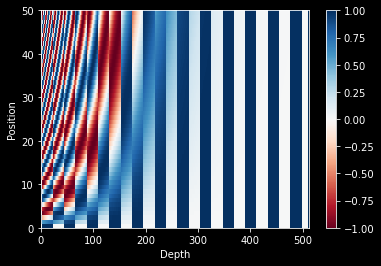

In [116]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.style.use('dark_background')
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [117]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [118]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [119]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [120]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

In [121]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [122]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [123]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [124]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [125]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [126]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [220]:
class CAMultiHeadAttention(tf.keras.models.Model):
    def __init__(self, d_model, num_heads):
        super(CAMultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads
        rank = int(d_model/2)
        
        self.wq = CASVDDenseAdd(d_model, rank)
        self.wk = CASVDDenseAdd(d_model, rank)
        self.wv = CASVDDenseAdd(d_model, rank)

        self.dense = CASVDDenseAdd(d_model, rank)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, c_v, c_k, c_q, mask):
        batch_size = tf.shape(q)[0]
        
        seq_len_q = tf.shape(q)[1]
        seq_len_k = tf.shape(k)[1]
        seq_len_v = tf.shape(v)[1]
        
        q = tf.reshape(q, (batch_size * seq_len_q, -1))
        k = tf.reshape(k, (batch_size * seq_len_k, -1))
        v = tf.reshape(v, (batch_size * seq_len_v, -1))
        
        c_q = tf.reshape(c_q, (batch_size * seq_len_q, -1))
        c_k = tf.reshape(c_k, (batch_size * seq_len_k, -1))
        c_v = tf.reshape(c_v, (batch_size * seq_len_v, -1))  

        q = self.wq((q, c_q))  # (batch_size * seq_len_q, d_model)
        k = self.wk((k, c_k))  # (batch_size * seq_len_k, d_model)
        v = self.wv((v, c_v))  # (batch_size * seq_len_v, d_model)
        
        q = tf.reshape(q, (batch_size, seq_len_q, self.d_model))
        k = tf.reshape(k, (batch_size, seq_len_k, self.d_model))
        v = tf.reshape(v, (batch_size, seq_len_v, self.d_model))

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        
        concat_attention = tf.reshape(scaled_attention, (batch_size * seq_len_q, self.d_model))  # (batch_size, seq_len_q, d_model)
        
        output = self.dense((concat_attention, c_q))  # (batch_size, seq_len_q, d_model)
        output = tf.reshape(output, (batch_size, seq_len_q, self.d_model))  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [221]:
d_model = 64
num_heads = 8

temp_mha = CAMultiHeadAttention(d_model, num_heads)
y = tf.random.uniform((2, 60, d_model))  # (batch_size, encoder_sequence, d_model)
c = tf.random.uniform((2, 60, d_model))
out, attn = temp_mha(v=y, k=y, q=y, c_q=c, c_k=c, c_v=c, mask=None)
out.shape, attn.shape

(TensorShape([2, 60, 64]), TensorShape([2, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [222]:
class CAPointWiseFeedForward(tf.keras.models.Model):
    def __init__(self, d_model, dff, activation: str = 'relu'):
        super(CAPointWiseFeedForward, self).__init__()
        self.d_model = d_model
        self.dff = dff
        self.non_linear = CASVDDenseAdd(dff, int(dff/2), activation=activation)  # (batch_size * seq_len, dff)
        self.linear = CASVDDenseAdd(d_model, int(d_model/2))  # (batch_size * seq_len, d_model)
        
    def call(self, inputs, context):
        batch_size = inputs.shape[0]
        seq_len = inputs.shape[1]
        
        inputs = tf.reshape(inputs, (batch_size * seq_len, -1))
        context = tf.reshape(inputs, (batch_size * seq_len, -1))
        
        inputs = self.non_linear((inputs, context))
        outputs = self.linear((inputs, context))
        return tf.reshape(outputs, (batch_size, seq_len, self.d_model))

In [223]:
sample_ffn = CAPointWiseFeedForward(64, 128)
sample_ffn(tf.random.uniform((64, 50, 512)), tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 64])

## Encoder and decoder

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [234]:
class EncoderLayer(tf.keras.models.Model):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = CAMultiHeadAttention(d_model, num_heads)
        self.ffn = CAPointWiseFeedForward(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, context, training, mask):
        attn_output, _ = self.mha(inputs, inputs, inputs, context, context, context, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1, context)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [225]:
sample_encoder_layer = EncoderLayer(32, 8, 64)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 32)), tf.random.uniform((64, 43, 32)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 32])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [296]:
class DecoderLayer(tf.keras.models.Model):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = CAMultiHeadAttention(d_model, num_heads)
        self.mha2 = CAMultiHeadAttention(d_model, num_heads)

        self.ffn = CAPointWiseFeedForward(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, inputs, input_context, encoder_output, encoder_context, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(inputs, inputs, inputs, input_context, input_context, input_context, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + inputs)

        attn2, attn_weights_block2 = self.mha2(
            encoder_output, encoder_output, out1, encoder_context, encoder_context, input_context, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2, input_context)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [297]:
sample_decoder_layer = DecoderLayer(32, 8, 64)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 32)), tf.random.uniform((64, 50, 32)), sample_encoder_layer_output, tf.random.uniform((64, 43, 32)),
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 32])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [298]:
class Encoder(tf.keras.models.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, inputs, context, training, mask):

        seq_len = tf.shape(inputs)[1]

        # adding embedding and position encoding.
        inputs = self.embedding(inputs)  # (batch_size, input_seq_len, d_model)
        inputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        inputs += self.pos_encoding[:, :seq_len, :]

        inputs = self.dropout(inputs, training=training)

        for i in range(self.num_layers):
            inputs = self.enc_layers[i](inputs, context, training, mask)

        return inputs  # (batch_size, input_seq_len, d_model)

In [299]:
sample_encoder = Encoder(num_layers=2, d_model=32, num_heads=8, 
                         dff=64, input_vocab_size=8500,
                         maximum_position_encoding=10000)

temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
temp_input_context = tf.random.uniform((64, 62, 32))

sample_encoder_output = sample_encoder(temp_input, temp_input_context, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 32)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [300]:
class Decoder(tf.keras.models.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, inputs, input_context, encoder_output, encoder_context, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(inputs)[1]
        attention_weights = {}

        inputs = self.embedding(inputs)  # (batch_size, target_seq_len, d_model)
        inputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        inputs += self.pos_encoding[:, :seq_len, :]

        inputs = self.dropout(inputs, training=training)

        for i in range(self.num_layers):
            inputs, block1, block2 = self.dec_layers[i](inputs, input_context, 
                                                   encoder_output, encoder_context,
                                                   training,
                                                   look_ahead_mask, 
                                                   padding_mask
                                                  )

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return inputs, attention_weights

In [301]:
sample_decoder = Decoder(num_layers=2, d_model=32, num_heads=8, 
                         dff=64, target_vocab_size=8000,
                         maximum_position_encoding=5000)

temp_target = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)
temp_target_context = tf.random.uniform((64, 26, 32))

output, attn = sample_decoder(temp_target,            
                              temp_target_context,
                              encoder_output=sample_encoder_output,
                              encoder_context=temp_input_context,
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 32]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [302]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, inp_c, tar, tar_c, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, inp_c, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, tar_c, enc_output, inp_c, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [303]:
sample_transformer = Transformer(
    num_layers=2, d_model=32, num_heads=8, dff=64, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_input_context = tf.random.uniform((64, 38, 32))
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)
temp_target_context = tf.random.uniform((64, 36, 32))

fn_out, _ = sample_transformer(temp_input, temp_input_context,
                               temp_target, temp_target_context,
                               training=True, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [289]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [405]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

# train_step_signature = [
#     tf.TensorSpec(shape=(None, None), dtype=tf.int64),
#     tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
#     tf.TensorSpec(shape=(None, None), dtype=tf.int64),
#     tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
# ]

def unpack(packed):
    unpacked = []
    for element in packed:
        if hasattr(element, 'layers'):
            for element in unpack(element.layers):
                unpacked.append(element)
        else:
            unpacked.append(element)   
    return unpacked

def train_step(inp, inp_c, tar, tar_c):
    tar_inp = tar[:, :-1]
    tar_c_inp = tar_c[:, :-1, :]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = sample_transformer(inp, inp_c, 
                                     tar_inp, tar_c_inp,
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

        gradients = tape.gradient(loss, sample_transformer.trainable_variables)    
        # Make gradients and variables zip
        grads_and_vars = zip(sample_transformer.trainable_variables, gradients)
        # Get svd layers
        svd_layers = [layer for layer in unpack([sample_transformer]) if 'svd' in layer.name]
        # Optimize svd layers
        for layer in svd_layers:
            # Get layer components (U, S, V, W)
            layer_variables = layer.trainable_variables[:-1]
            # Get gradients and variables for components
            (u, s, v, w) , (du, ds, dv, dw) = zip(*[(v, g) for v, g in grads_and_vars if v.name in [var.name for var in layer_variables]])
            # Update gradients and variables zip to not contain these layer's components
            grads_and_vars = [(v, g) for v, g in grads_and_vars if v.name not in [var.name for var in layer_variables]]
            # Calculate orthogonal update
            chi_u = chi(u, du, nu)
            chi_v = chi(v, dv, nu)
            u_update = u + chi_u @ u
            v_update = v + chi_v @ v
            # Context updated coefficients
            c = tf.reshape(inp_c, (-1, w.shape[0]))
            s_ = s + c@w
            # calculate assembled gradient
            dk = batch_assembled_gradient(u, s_, v, du, ds, dv)
            # Calculate singular value updates
            psi_u = tf.transpose(u)@chi_u@u
            psi_v = tf.transpose(v)@chi_v@v
            s_matrix = tf.linalg.diag(s_)
            s_update_matrix = psi_u@s_matrix + (s_matrix + psi_u@s_matrix)@tf.transpose(psi_v)  - learning_rate * (
                tf.transpose(u_update)@dk@v_update + tf.linalg.diag(c@dw)
            )
            # Update orthogonal matrices
            u.assign_add(chi_u @ u)
            v.assign_add(chi_v @ v)
            # Update singular values
            s.assign_add(tf.reduce_mean(tf.linalg.diag_part(s_update_matrix), axis=0))
            # regular updates
            w.assign_add(-learning_rate * dw)            
        # Optimize other variables
        for variable, gradient in grads_and_vars:
            variable.assign_add(-learning_rate * gradient)

    train_loss(loss)
    # train_accuracy(accuracy_function(tar_real, predictions))

In [406]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [442]:
train_dataset = tf.data.Dataset.from_tensor_slices((temp_input, temp_input_context, temp_target, temp_target_context)).batch(2)

EPOCHS = 1
nu = 10e-4
learning_rate = 10e-4

optimizer = tf.keras.optimizers.SGD()

loss_object = tf.keras.losses.sparse_categorical_crossentropy

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')


# Get svd layers
svd_layers = [layer for layer in unpack([sample_transformer]) if 'svd' in layer.name]

for epoch in range(EPOCHS):
    start = time.time()

    train_loss
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for batch, (inp, inp_c, tar, tar_c) in enumerate(train_dataset):
        tar_inp = tar[:, :-1]
        tar_c_inp = tar_c[:, :-1, :]
        tar_real = tar[:, 1:]

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

        with tf.GradientTape() as tape:
            predictions, _ = sample_transformer(inp, inp_c, 
                                         tar_inp, tar_c_inp,
                                         True, 
                                         enc_padding_mask, 
                                         combined_mask, 
                                         dec_padding_mask)
            loss = loss_function(tar_real, predictions)

            gradients = tape.gradient(loss, sample_transformer.trainable_variables)    
        # Make gradients and variables zip
        grads_and_vars = zip(gradients, sample_transformer.trainable_variables)
        svd_indices = []
        # Optimize svd layers
        for layer in svd_layers:
            # Get layer components (U, S, V, W)
            layer_variables = layer.trainable_variables[:-1]
            # variable indices
            variable_indices = [idx for idx, v in enumerate(sample_transformer.trainable_variables) 
                                if v.name in [var.name for var in layer_variables]]
            # Get gradients and variables for components
            u, s, v, w = layer_variables
            du, ds, dv, dw = np.array(gradients)[variable_indices]
            svd_indices = np.concatenate([svd_indices, variable_indices])
            # Calculate orthogonal update
            chi_u = chi(u, du, nu)
            chi_v = chi(v, dv, nu)
            u_update = u + chi_u @ u
            v_update = v + chi_v @ v
            # Context updated coefficients depending on encoder or decoder
            c = inp_c if 'encoder' in layer.name else tar_c_inp
            c = tf.reshape(c, (-1, w.shape[0]))
            s_ = s + c@w
            # calculate assembled gradient
            dk = batch_assembled_gradient(u, s_, v, du, ds, dv)
            # Calculate singular value updates
            psi_u = tf.transpose(u)@chi_u@u
            psi_v = tf.transpose(v)@chi_v@v
            s_matrix = tf.linalg.diag(s_)
            s_update_matrix = psi_u@s_matrix + (s_matrix + psi_u@s_matrix)@tf.transpose(psi_v)  - learning_rate * (
                tf.transpose(u_update)@dk@v_update + tf.linalg.diag(c@dw)
            )
            # Update orthogonal matrices
            u.assign_add(chi_u @ u)
            v.assign_add(chi_v @ v)
            # Update singular values
            s.assign_add(tf.reduce_mean(tf.linalg.diag_part(s_update_matrix), axis=0))
            # regular updates
            w.assign_add(-learning_rate * dw)            
        # Optimize other variables
        optimizer.apply_gradients([(g, v) for idx, (g,v) in enumerate(grads_and_vars) if idx not in svd_indices])
            
        train_loss(loss)
        # train_accuracy(accuracy_function(tar_real, predictions))
    
    print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
        epoch + 1, batch, train_loss.result(), train_accuracy.result()))

Epoch 1 Batch 31 Loss 8.1558 Accuracy 0.0000
